# Contiguity Tests

## Job pipeline use case

- jobs have a projected runtime
- jobs can have an averaged fixed or variable cpu utilization. Variable cpu utilization has some relationship to server power draw
- jobs can be scheduled to run throughout the day
- some jobs will have fixed complete by times

In [1]:
import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import numpy as np
import pandas as pd
from watttime import WattTimeHistorical, WattTimeForecast
import data.dataset as od
import evaluation.eval_framework as evu
import data.s3 as s3u
import math
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

In [2]:
# test dates
dates_2024 = evu.generate_random_dates(2024)
distinct_date_list = dates_2024

# criteria
kwargs = {
    "power_output_max_rates": [240,310,400], # assuming a bare metal usecase, k8s or vm rescale to vCPU
    "start_hour": "00:00:00",  # earliest session can start
    "end_hour": "23:59:00",  # latest session can start
    "user_charge_tolerance":1.0 # job must run to completion
}

In [4]:
dfs = evu.execute_synth_data_process(
    distinct_date_list=distinct_date_list, number_of_users=100, **kwargs
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 66.00it/s]


Text(0.5, 1.0, 'length_of_session_in_seconds')

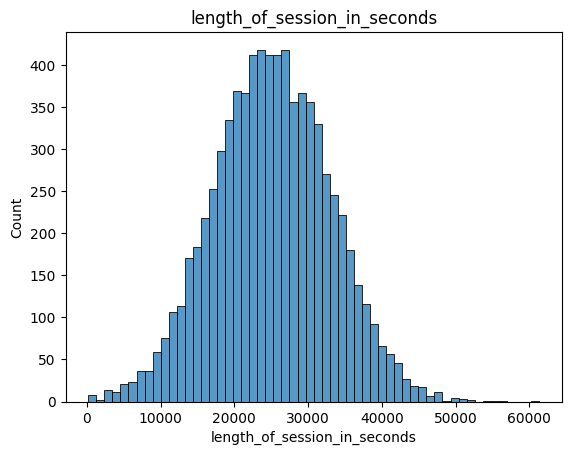

In [5]:
sns.histplot(dfs["length_of_session_in_seconds"]).set_title(
    "length_of_session_in_seconds"
)

Text(0.5, 1.0, 'power_output_rate')

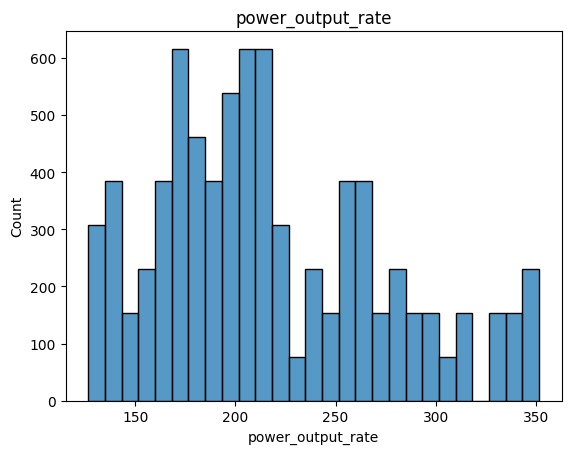

In [7]:
sns.histplot(dfs["power_output_rate"]).set_title(
    "power_output_rate"
)

In [8]:
synth_data = dfs.sample(100).copy(deep=True)

In [51]:
region = "PJM_NJ"

synth_data["moer_data"] = synth_data.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [52]:
synth_data["moer_data_actual"] = synth_data.apply( 
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [53]:
get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
get_total_emissions_lambda = lambda x: x["emissions_co2e_lb"].sum()

In [54]:
synth_data["optimizer_ideal"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        total_intervals = 1,
        usage_power_kw=x.power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data_actual,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["ideal_charging_schedule"] = synth_data[
    "optimizer_ideal"
].apply(get_charging_schedule_lambda)
synth_data["ideal_emissions"] = synth_data["optimizer_ideal"].apply(
    get_total_emissions_lambda
)

== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous fit! ==
== Sophisticated contiguous 

In [55]:
%%capture
synth_data["optimizer_simple"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        total_intervals=1,
        usage_power_kw=x.power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["optimizer_simple_schedule"] = synth_data["optimizer_simple"].apply(
    get_charging_schedule_lambda
)

synth_data["simple_estimated_emissions"] = synth_data[
    "optimizer_simple"
].apply(get_total_emissions_lambda)
synth_data["simple_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_simple.energy_usage_mwh,
    ),
    axis=1
)

In [56]:
%%capture
synth_data["optimizer_baseline"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        total_intervals=1,
        usage_power_kw=x.power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="baseline",
    ),
    axis=1,
)

synth_data["baseline_schedule"] = synth_data["optimizer_baseline"].apply(
    get_charging_schedule_lambda
)
synth_data["baseline_estimated_emissions"] = synth_data[
    "optimizer_baseline"
].apply(get_total_emissions_lambda)
synth_data["baseline_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_baseline.energy_usage_mwh,
    ),
    axis=1,
)

## Metrics

In [57]:
synth_data["baseline_difference"] = (
    synth_data["simple_actual_emissions"]
    - synth_data["baseline_actual_emissions"]
)
synth_data["largest_possible_difference"] = (
    synth_data["ideal_emissions"]
    - synth_data["baseline_actual_emissions"]
)

synth_data["percent_achieved"] = np.divide(synth_data["baseline_difference"],synth_data["largest_possible_difference"])

In [58]:
ratio_list = []
for index, row in synth_data.iterrows():
    ratio = SequenceMatcher(None, row["optimizer_simple_schedule"], row["baseline_schedule"]).ratio()
    ratio_list.append(ratio)

In [59]:
synth_data["schedule_diff_ratio"] = ratio_list

## Charts

In [60]:
synth_data[["schedule_diff_ratio","percent_achieved"]].corr(method='spearman')

,schedule_diff_ratio,percent_achieved
schedule_diff_ratio,1.000000,-0.045901
percent_achieved,-0.045901,1.000000


<Axes: xlabel='schedule_diff_ratio', ylabel='Count'>

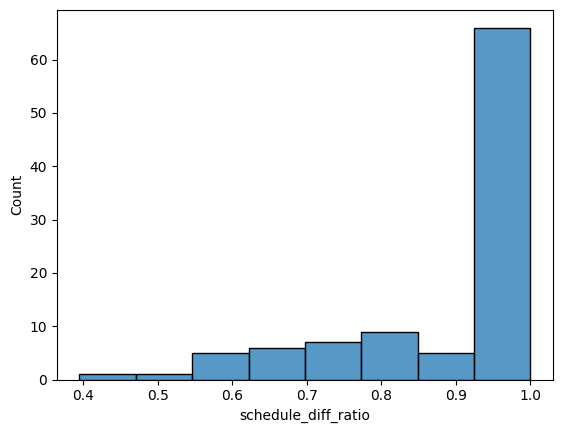

In [61]:
sns.histplot(synth_data["schedule_diff_ratio"])

<Axes: xlabel='distinct_dates'>

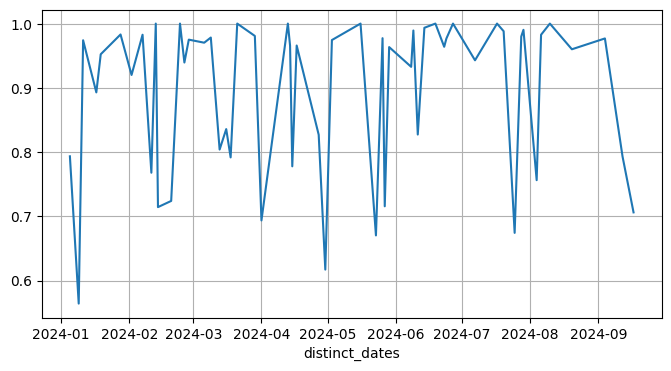

In [62]:
synth_data.groupby(["distinct_dates"])["schedule_diff_ratio"].median().plot(grid=True, figsize=(8, 4))

<Axes: xlabel='baseline_difference', ylabel='Count'>

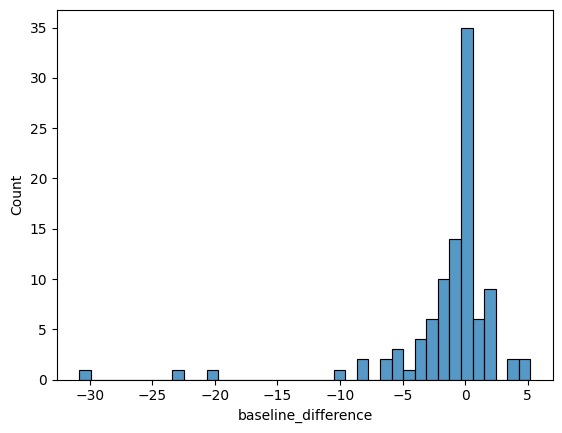

In [63]:
sns.histplot(synth_data["baseline_difference"])

<Axes: xlabel='largest_possible_difference', ylabel='Count'>

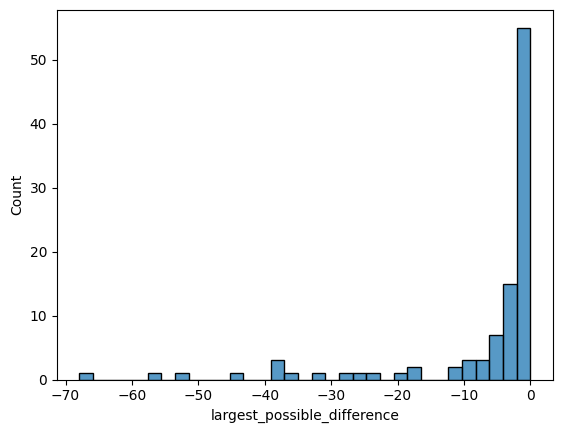

In [64]:
sns.histplot(synth_data["largest_possible_difference"])

In [65]:
synth_data["baseline_actual_emissions"].sum() - synth_data["simple_actual_emissions"].sum()

148.26354666666703

<Axes: xlabel='distinct_dates'>

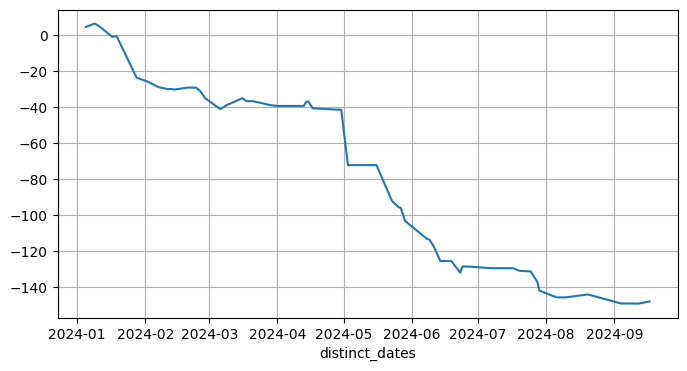

In [66]:
# downward trend despite some issues re: forecast error
synth_data.groupby(["distinct_dates"])["baseline_difference"].sum().cumsum().plot(grid=True, figsize=(8, 4))

In [67]:
pkl = pickle.dumps(synth_data)
s3.store_dictionary(dictionary=pkl, file=f"{region}_contiguity_20240929.pkl")

Successful S3 put_object response. Status - 200
